<a href="https://colab.research.google.com/github/aaronjoseph/NLP_Boiler_Plate/blob/main/TM_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importin packages
# from preprocessing import tokenize, export_to_csv
# from GSDMM import MovieGroupProcess
# from topic_allocation import top_words, topic_attribution
# from visualisation import plot_topic_notebook, save_topic_html
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from nltk.tokenize import TweetTokenizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

import pickle
import matplotlib as plt
import pandas as pd
import numpy as np
import ast

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Basically data consists of 3 main topics:
- Mideast Politics 🌍
- Space 👾
- Windows X 🖥

In [ ]:
cats = ['talk.politics.mideast', 'comp.windows.x', 'sci.space']

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=cats)
newsgroups_train_subject = fetch_20newsgroups(subset='train', categories=cats)

data = newsgroups_train.data
data_subject = newsgroups_train_subject.data

targets = newsgroups_train.target.tolist()
target_names = newsgroups_train.target_names
df_targets = pd.DataFrame({'targets': targets})
order_list = df_targets.targets.value_counts()
def extract_first_sentence(data_subject):
    list_first_sentence = []
    for text in data:
        first_sentence = text.split(".")[0].replace("\n", "")
        list_first_sentence.append(first_sentence)
    return list_first_sentence


def extract_subject(data):
    c = 0
    s = "Subject:"
    list_subjects = []
    for new in data_subject:    
        lines = new.split("\n")
        b = 0 # loop out at the first "Subject:", they may be several and we want first one only
        for line in lines:
            if s in line and b == 0:
                subject = " ".join(line.split(":")[1:]).strip()
                subject = subject.replace('Re', '').strip()
                list_subjects.append(subject)
                c += 1
                b = 1
    return list_subjects
   
    
def concatenate(list_first_sentence, list_subjects):
    list_docs = []
    for i in range(len(list_first_sentence)):
        list_docs.append(list_subjects[i] + " " + list_first_sentence[i])
    return list_docs


list_first_sentence = extract_first_sentence(data)
list_subjects = extract_subject(data_subject)
list_docs = concatenate(list_first_sentence, list_subjects)

df = pd.DataFrame(columns=['content', 'topic_id', 'topic_true_name'])
df['content'] = list_docs
df['topic_id'] = targets


def true_topic_name(x, target_names):
    return target_names[x].split('.')[-1]
    
df['topic_true_name'] = df['topic_id'].apply(lambda x: true_topic_name(x, target_names))
df.head()

,content,topic_id,topic_true_name
0,Elevator to the top floor Reading from a Amoco...,1,space
1,"Title for XTerm Yet again,the escape sequences...",0,x
2,From Israeli press. Madness. Before getting ex...,2,mideast
3,Accounts of Anti-Armenian Human Right Violatio...,2,mideast
4,How many israeli soldiers does it take to kill...,2,mideast


### Visualization 

In [ ]:
df['Number_of_words'] = df['content'].apply(lambda x:len(str(x).split()))
df

,content,topic_id,topic_true_name,Number_of_words
0,Elevator to the top floor Reading from a Amoco...,1,space,26
1,"Title for XTerm Yet again,the escape sequences...",0,x,16
2,From Israeli press. Madness. Before getting ex...,2,mideast,23
3,Accounts of Anti-Armenian Human Right Violatio...,2,mideast,51
4,How many israeli soldiers does it take to kill...,2,mideast,21
...,...,...,...,...
1745,Atlas revisited I found it very interesting ...,1,space,15
1746,How to get 24bit color with xview frames ? Yes,0,x,10
1747,Deir Yassin You apparently think you are some ...,2,mideast,25
1748,"Vulcan? (No, not the guy with the ears!) The ...",1,space,13


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each text extracted')

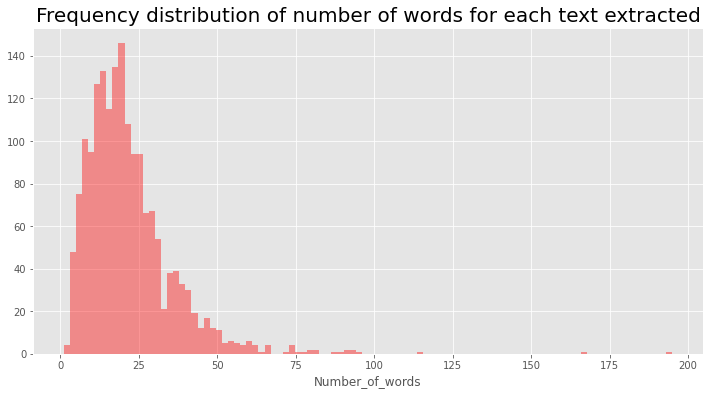

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df['Number_of_words'],kde = False,color="red", bins = 100)
plt.title("Frequency distribution of number of words for each text extracted", size=20)

In [ ]:
# just in case required
# def cleaned_text(text):
#     clean = re.sub("\n"," ",text)
#     clean=clean.lower()
#     clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
#     clean=re.sub("[^a-z]"," ",clean)
#     clean=clean.lstrip()
#     clean=re.sub("\s{2,}"," ",clean)
#     return clean
# data["cleaned_paper_text"]=data["paper_text"].apply(cleaned_text)



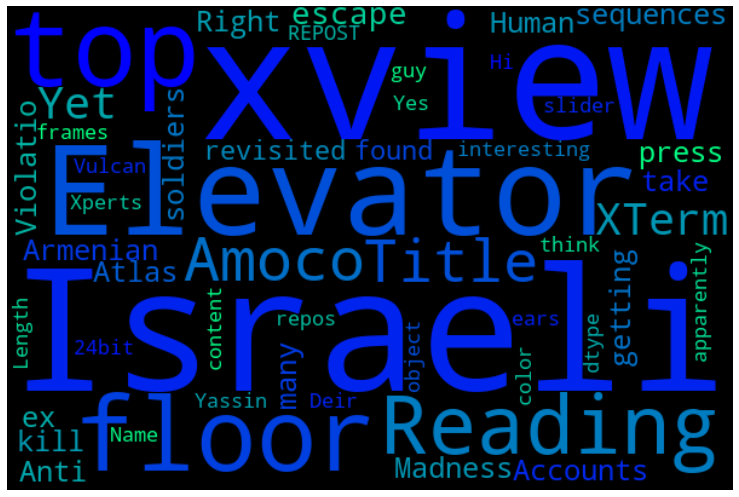

In [ ]:
cloud=WordCloud(colormap="winter",width=600,height=400).generate(str(df["content"]))
fig=plt.figure(figsize=(13,18))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear')

Now we will do the next step cleaning process which is stop word removal and then we will lemmatize the words.

In [ ]:
stop=stopwords.words('english')
stop.append("also")
df["stop_removed_paper_text"]=df["content"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df

,content,topic_id,topic_true_name,Number_of_words,stop_removed_paper_text
0,Elevator to the top floor Reading from a Amoco...,1,space,26,Elevator top floor Reading Amoco Performance P...
1,"Title for XTerm Yet again,the escape sequences...",0,x,16,"Title XTerm Yet again,the escape sequences spe..."
2,From Israeli press. Madness. Before getting ex...,2,mideast,23,From Israeli press. Madness. Before getting ex...
3,Accounts of Anti-Armenian Human Right Violatio...,2,mideast,51,Accounts Anti-Armenian Human Right Violations ...
4,How many israeli soldiers does it take to kill...,2,mideast,21,How many israeli soldiers take kill 5 yr old c...
...,...,...,...,...,...
1745,Atlas revisited I found it very interesting ...,1,space,15,Atlas revisited I found interesting Atlas depe...
1746,How to get 24bit color with xview frames ? Yes,0,x,10,How get 24bit color xview frames ? Yes
1747,Deir Yassin You apparently think you are some ...,2,mideast,25,Deir Yassin You apparently think sort one-man ...
1748,"Vulcan? (No, not the guy with the ears!) The ...",1,space,13,"Vulcan? (No, guy ears!) The sightings apparent..."


In [ ]:
# Create a reference variable for Class word_tokenize 
tk = TweetTokenizer() 
df["tokenized"]=df["stop_removed_paper_text"].apply(lambda x: tk.tokenize(x))
df

,content,topic_id,topic_true_name,Number_of_words,stop_removed_paper_text,tokenized
0,Elevator to the top floor Reading from a Amoco...,1,space,26,Elevator top floor Reading Amoco Performance P...,"[Elevator, top, floor, Reading, Amoco, Perform..."
1,"Title for XTerm Yet again,the escape sequences...",0,x,16,"Title XTerm Yet again,the escape sequences spe...","[Title, XTerm, Yet, again, ,, the, escape, seq..."
2,From Israeli press. Madness. Before getting ex...,2,mideast,23,From Israeli press. Madness. Before getting ex...,"[From, Israeli, press, ., Madness, ., Before, ..."
3,Accounts of Anti-Armenian Human Right Violatio...,2,mideast,51,Accounts Anti-Armenian Human Right Violations ...,"[Accounts, Anti-Armenian, Human, Right, Violat..."
4,How many israeli soldiers does it take to kill...,2,mideast,21,How many israeli soldiers take kill 5 yr old c...,"[How, many, israeli, soldiers, take, kill, 5, ..."
...,...,...,...,...,...,...
1745,Atlas revisited I found it very interesting ...,1,space,15,Atlas revisited I found interesting Atlas depe...,"[Atlas, revisited, I, found, interesting, Atla..."
1746,How to get 24bit color with xview frames ? Yes,0,x,10,How get 24bit color xview frames ? Yes,"[How, get, 24bit, color, xview, frames, ?, Yes]"
1747,Deir Yassin You apparently think you are some ...,2,mideast,25,Deir Yassin You apparently think sort one-man ...,"[Deir, Yassin, You, apparently, think, sort, o..."
1748,"Vulcan? (No, not the guy with the ears!) The ...",1,space,13,"Vulcan? (No, guy ears!) The sightings apparent...","[Vulcan, ?, (, No, ,, guy, ears, !, ), The, si..."


In [ ]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df["lemmatized"]=df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["lemmatize_joined"]=df["lemmatized"].apply(lambda x: ' '.join(x))
pd.set_option('display.max_colwidth', 100)
df

,content,topic_id,topic_true_name,Number_of_words,stop_removed_paper_text,tokenized,lemmatized,lemmatize_joined
0,"Elevator to the top floor Reading from a Amoco Performance Products data sheet, theirERL-1906 re...",1,space,26,"Elevator top floor Reading Amoco Performance Products data sheet, theirERL-1906 resin T40 carbon...","[Elevator, top, floor, Reading, Amoco, Performance, Products, data, sheet, ,, theirERL, -, 1906,...","[Elevator, top, floor, Reading, Amoco, Performance, Products, data, sheet, ,, theirERL, -, 1906,...","Elevator top floor Reading Amoco Performance Products data sheet , theirERL - 1906 resin T40 car..."
1,"Title for XTerm Yet again,the escape sequences you are speaking about here are non standard andd...",0,x,16,"Title XTerm Yet again,the escape sequences speaking non standard anddangerous","[Title, XTerm, Yet, again, ,, the, escape, sequences, speaking, non, standard, anddangerous]","[Title, XTerm, Yet, again, ,, the, escape, sequence, speak, non, standard, anddangerous]","Title XTerm Yet again , the escape sequence speak non standard anddangerous"
2,"From Israeli press. Madness. Before getting excited and implying that I am postingfabrications, ...",2,mideast,23,"From Israeli press. Madness. Before getting excited implying I postingfabrications, I would sugg...","[From, Israeli, press, ., Madness, ., Before, getting, excited, implying, I, postingfabrications...","[From, Israeli, press, ., Madness, ., Before, get, excite, imply, I, postingfabrications, ,, I, ...","From Israeli press . Madness . Before get excite imply I postingfabrications , I would suggest r..."
3,Accounts of Anti-Armenian Human Right Violations in Azerbaijan #011 Accounts of Anti-Armenian Hu...,2,mideast,51,Accounts Anti-Armenian Human Right Violations Azerbaijan #011 Accounts Anti-Armenian Human Right...,"[Accounts, Anti-Armenian, Human, Right, Violations, Azerbaijan, #011, Accounts, Anti-Armenian, H...","[Accounts, Anti-Armenian, Human, Right, Violations, Azerbaijan, #011, Accounts, Anti-Armenian, H...",Accounts Anti-Armenian Human Right Violations Azerbaijan #011 Accounts Anti-Armenian Human Right...
4,How many israeli soldiers does it take to kill a 5 yr old child? Probably not--he's just singing...,2,mideast,21,How many israeli soldiers take kill 5 yr old child? Probably not--he's singing someone else's opera,"[How, many, israeli, soldiers, take, kill, 5, yr, old, child, ?, Probably, not--he's, singing, s...","[How, many, israeli, soldier, take, kill, 5, yr, old, child, ?, Probably, not--he's, sing, someo...",How many israeli soldier take kill 5 yr old child ? Probably not--he's sing someone else's opera
...,...,...,...,...,...,...,...,...
1745,Atlas revisited I found it very interesting that Atlas depended on pressure tomaintain tank ge...,1,space,15,Atlas revisited I found interesting Atlas depended pressure tomaintain tank geometry,"[Atlas, revisited, I, found, interesting, Atlas, depended, pressure, tomaintain, tank, geometry]","[Atlas, revisit, I, find, interest, Atlas, depend, pressure, tomaintain, tank, geometry]",Atlas revisit I find interest Atlas depend pressure tomaintain tank geometry
1746,How to get 24bit color with xview frames ? Yes,0,x,10,How get 24bit color xview frames ? Yes,"[How, get, 24bit, color, xview, frames, ?, Yes]","[How, get, 24bit, color, xview, frame, ?, Yes]",How get 24bit color xview frame ? Yes
1747,"Deir Yassin You apparently think you are some sort of one-man judge and jury whocan declare ""tot...",2,mideast,25,"Deir Yassin You apparently think sort one-man judge jury whocan declare ""total"" victory sit back...","[Deir, Yassin, You, apparently, think, sort, one-man, judge, jury, whocan, declare, "", total, "",...","[Deir, Yassin, You, apparently, think, sort, one-man, judge, jury, whocan, declare, "", total, "",...","Deir Yassin You apparently think sort one-man judge jury whocan declare "" total "" victory sit ba..."
1748,"Vulcan? (No, not the guy with the ears!) The sightings were apparently